
```
"""
HIGH DIMENSION ANALYSIS
Programing excercise: 02
Name: Tieu Khoi Mai
Student Code: 1711159
"""
```



#1. Apply LCA for Iris dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Bước 1: 
- Lấy X là các đặc trưng của data bao gồm: sepal_length, sepal_width, petal_length, petal_width
- Lấy y là cột species của dữ liệu



In [ ]:
X = iris.iloc[:,0:4]
y = iris.iloc[:,-1]

Bước 2: Feature Engineering - Ta nhận thấy y (species) là một thuộc tính phân loại danh nghĩa (nominal). Vì vậy ta sử dụng label encoding để ánh xạ từng danh mục thành giá trị số bằng cách sử dụng scikit-learn

In [ ]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(y)

Như vậy chúng ta đã có được một ánh xạ trong đó mỗi giá trị của genre được ánh xạ với một số (numberic) theo output : 

```
#{'setosa': 0, 'versicolor': 1, 'virginica': 2}
```




In [ ]:
le_name_mapping = dict(zip(class_le.classes_, class_le.transform(class_le.classes_)))
print(le_name_mapping)

{'setosa': 0, 'versicolor': 1, 'virginica': 2}


Bước 3: Standardize 4 chiều của đặc trưng

In [ ]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X)

Bước 4: Tính S_W (within-class)
* $ s_W = \sum_{i = 1}^c s_i $
* $ s_i = \sum_{x \in {D}_i}^c (x - m_i) (x - m_i)^T$

In [ ]:
S_W = np.zeros((4,4))
for i in range(3):
    S_W += np.cov(X_train_std[y==i].T)

In [ ]:
S_W

array([[1.16722735, 0.77586555, 0.34609473, 0.1837458 ],
       [0.77586555, 1.83433822, 0.21683848, 0.29734854],
       [0.34609473, 0.21683848, 0.17947433, 0.09576187],
       [0.1837458 , 0.29734854, 0.09576187, 0.21770532]])

Bước 5: Tính S_B (between class)
* $ S_B =  \sum\limits_{i=1}^{c} N_{i} ( m_i - m) ( m_i - m)^T $

In [ ]:
N=np.bincount(y) # number of samples for given class
vecs=[]
[vecs.append(np.mean(X_train_std[y==i],axis=0)) for i in range(3)] # class means
mean_overall = np.mean(X_train_std, axis=0) # overall mean
S_B=np.zeros((4,4))
for i in range(3):
    S_B += N[i]*(((vecs[i]-mean_overall).reshape(4,1)).dot(((vecs[i]-mean_overall).reshape(1,4))))

In [ ]:
S_B

array([[ 92.80585961, -55.65287963, 113.80442453, 113.68762457],
       [-55.65287963,  60.11742706, -74.89110136, -69.48896849],
       [113.80442453, -74.89110136, 141.20575786, 139.73748309],
       [113.68762457, -69.48896849, 139.73748309, 139.33243952]])

Bước 5: Nghiệm là vector riêng ứng với trị riêng lớn nhất của $S_{W}^{-1} S_{B}$

In [ ]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

1577.404530715622
13.98416108853057
4.5303956614059127e-13
5.431127306690105e-14


In [ ]:
print('Variance explained:\n')
eigv_sum = sum(eigen_vals)
for i,j in enumerate(eigen_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.12%
eigenvalue 2: 0.88%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


Bước 6: Dựa vào biểu đồ cùng bảng trên ta có thể thấy với eigenvalue, giải thích được 99.12% dữ liệu. Vì vậy LD2 không có ý nghĩa quá nhiều tức là có thể chọn 1 hoặc 2

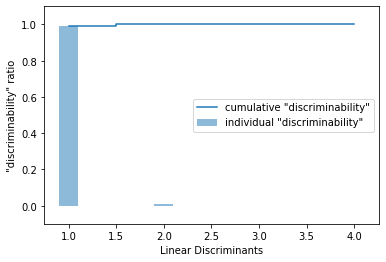

In [ ]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 5), discr, width=0.2,alpha=0.5, align='center',label='individual "discriminability"')
plt.step(range(1, 5), cum_discr, where='mid',label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

Bước cuối: Ta chọn ra được 2 cột egienvector để tạo ra ma trận ánh xạ W. Chiếu đặc trưng gốc lên không gian mới bằng $X' = XW$ sau đó plot lên

In [ ]:
W=np.hstack((eigen_pairs[0][1][:, ].reshape(4,1),eigen_pairs[1][1][:, ].reshape(4,1))).real
X_train_lda = X_train_std.dot(W)

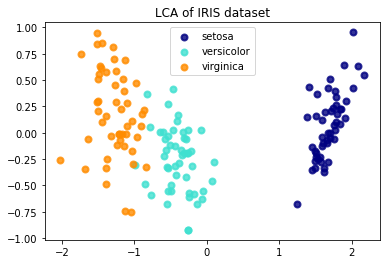

In [ ]:
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

target_names = ['setosa', 'versicolor', 'virginica']

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_train_lda[y == i, 0], X_train_lda[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LCA of IRIS dataset')

plt.show()

# 2. Apply PCA for Iris dataset by sklearn

explained variance ratio (first two components): [0.92461872 0.05306648]


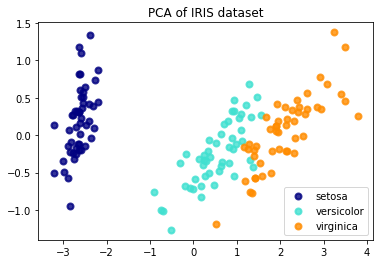

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.show()